In [1]:
import tensorflow as tf

In [2]:
gpu_fraction = 0.1
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [4]:
# 동일한 결과를 재현하기 위해서 random seed 고정
import numpy as np

np.random.seed(777)

In [6]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (warning)
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

In [7]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [7]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [8]:
print(train_targets) # 단위: 천 달러

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

In [8]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

# 테스트 셋도 훈련 셋에서 계산된 mean과 std를 동일하게 사용함
# 만약 각각 정규화를 수행해버리면, 학습 결과 적용이 불가능해짐
test_data -= mean
test_data /= std

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1)) # 회귀 모델 (출력층에 활성화 함수 없음)
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

In [11]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('>> fold ', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                            train_targets[(i+1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    model.fit(partial_train_data, 
              partial_train_targets,
              epochs = num_epochs,
              batch_size = 1,
              verbose = 0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print('finished!!')

>> fold  0
>> fold  1
>> fold  2
>> fold  3
finished!!


In [12]:
print(all_scores)
mean = np.mean(all_scores)
stddev = np.std(all_scores)

print(u'%.2f \u00B1(%.2f)'%(mean, stddev))

[2.2316887, 2.6087942, 2.6762898, 2.389614]
2.48 ±(0.18)


In [13]:
'''
4-fold의 평균 validation MAE 그래프 그리기
'''

print(model.metrics_names)

['loss', 'mean_absolute_error']


In [10]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 250
all_mae_histories = []

for i in range(k):
    print('>> fold ', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                            train_targets[(i+1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    hist = model.fit(partial_train_data, 
                     partial_train_targets,
                     epochs = num_epochs,
                     batch_size = 1,
                     verbose = 0,
                     validation_data = (val_data, val_targets))
    
    mae_history = hist.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
print('finished!!')

>> fold  0
>> fold  1
>> fold  2
>> fold  3
finished!!


In [11]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# print 는 너무 길어서 걍 생략

In [12]:
average_mae_history = []
for epoch in range(num_epochs):
    average_mae_per_epoch = []
    
    for mae_history in all_mae_histories: # 4개 fold 반복
        average_mae_per_epoch.append(mae_history[epoch])
    
    mean = np.mean(average_mae_per_epoch)
    average_mae_history.append(mean)

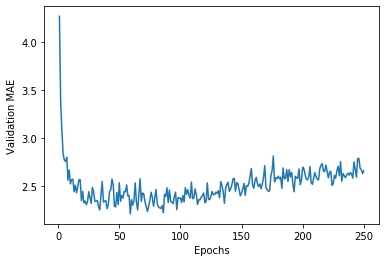

In [13]:
import matplotlib.pyplot as plt

# matplotlib이 Jupyter notebook 셀 안에서 생성되도록 함
# https://versusall.tistory.com/entry/Jupyter-Notebook-4-%EC%99%B8%EB%B6%80%EC%B0%BD%EC%97%90%EC%84%9C-%EA%B7%B8%EB%9E%98%ED%94%84-%EA%B7%B8%EB%A6%AC%EA%B8%B0-matplotlib-inline-qt-tk%C2%B6
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

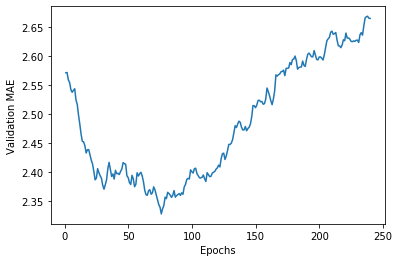

In [14]:
'''
시계열 신호에 지수 이동 평균(exponential moving averge) 필터링
'''
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(prev*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [15]:
# 기존 model 객체를 사용하면 이어서 학습되므로, 새로운 model 객체를 생성함
model = build_model()
model.fit(train_data, 
          train_targets,
          epochs = 80,
          batch_size = 16,
          verbose = 1)

Epoch 1/80
404/404 [==============================] - 0s 348us/sample - loss: 506.5347 - mean_absolute_error: 20.4841
Epoch 2/80
404/404 [==============================] - 0s 163us/sample - loss: 341.7886 - mean_absolute_error: 16.2218 - loss: 357.9567 - mean_absolute_error: 16.59
Epoch 3/80
404/404 [==============================] - 0s 183us/sample - loss: 175.4588 - mean_absolute_error: 10.7911
Epoch 4/80
404/404 [==============================] - 0s 193us/sample - loss: 71.6970 - mean_absolute_error: 6.4424
Epoch 5/80
404/404 [==============================] - 0s 237us/sample - loss: 40.7013 - mean_absolute_error: 4.7520
Epoch 6/80
404/404 [==============================] - 0s 185us/sample - loss: 28.4515 - mean_absolute_error: 3.8549
Epoch 7/80
404/404 [==============================] - 0s 156us/sample - loss: 22.9386 - mean_absolute_error: 3.3907 - loss: 23.4242 - mean_absolute_error: 3.41
Epoch 8/80
404/404 [==============================] - 0s 156us/sample - loss: 20.3334 - mean

404/404 [==============================] - 0s 175us/sample - loss: 6.6789 - mean_absolute_error: 1.8111
Epoch 71/80
404/404 [==============================] - 0s 173us/sample - loss: 6.6409 - mean_absolute_error: 1.8175
Epoch 72/80
404/404 [==============================] - 0s 143us/sample - loss: 6.4728 - mean_absolute_error: 1.8199
Epoch 73/80
404/404 [==============================] - 0s 141us/sample - loss: 6.6059 - mean_absolute_error: 1.8000
Epoch 74/80
404/404 [==============================] - 0s 151us/sample - loss: 6.5238 - mean_absolute_error: 1.8231
Epoch 75/80
404/404 [==============================] - 0s 153us/sample - loss: 6.3049 - mean_absolute_error: 1.7582
Epoch 76/80
404/404 [==============================] - 0s 163us/sample - loss: 6.6176 - mean_absolute_error: 1.8088
Epoch 77/80
404/404 [==============================] - 0s 170us/sample - loss: 6.4235 - mean_absolute_error: 1.7252
Epoch 78/80
404/404 [==============================] - 0s 146us/sample - loss: 6.414

In [16]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print('test MSE score: %.3f', test_mse_score)
print('test MAE score: %.3f', test_mae_score)

102/102 [==============================] - 0s 313us/sample - loss: 16.9047 - mean_absolute_error: 2.7197
test MSE score: %.3f 16.904688666848575
test MAE score: %.3f 2.7197444
